In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
# import xgboost as xgb

import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

2024-07-21 09:51:21.759959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 09:51:26.502636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-21 09:51:26.504520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
file_path = "Dataset.csv"
df = pd.read_csv(file_path, index_col = 0)
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [3]:
columns_for_baseline = ['Hour', 'HR','O2Sat', 'Temp','SBP', 'MAP', 'DBP', 'Resp','Age','Gender','Patient_ID','SepsisLabel']

In [4]:
df1 = df[columns_for_baseline]

In [5]:
# Filter patient IDs where at some point sepsis label is 1
sepsis_patients_ids = list(set(df1.loc[df1['SepsisLabel'] == 1, 'Patient_ID'].tolist()))
# Get unique Patient_IDs from df_encoded
all_patient_ids = set(df1['Patient_ID'])
# Find Patient_IDs not in sepsis_patients_ids
no_sepsis_patients_ids = list(all_patient_ids - set(sepsis_patients_ids))

In [6]:
non_sepsis_selected_patients_ids = random.sample(no_sepsis_patients_ids, 4000)

In [7]:
non_sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(non_sepsis_selected_patients_ids)]
sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(sepsis_patients_ids)]
final_df = pd.concat([non_sepsis_selected_df,sepsis_selected_df])

In [8]:
patient_ids = final_df['Patient_ID'].unique()
np.random.shuffle(patient_ids)

In [9]:
final_df.Patient_ID = final_df.Patient_ID.astype("category")
final_df.Patient_ID = final_df.Patient_ID.cat.set_categories(patient_ids)
final_df_shuffled = final_df.sort_values(["Patient_ID", "Hour"]).set_index('Patient_ID')  ## 'sort' changed to 'patient_ids'

In [10]:
final_df.Patient_ID = final_df.Patient_ID.astype("int")

df_filled = final_df.groupby('Patient_ID', group_keys=False).apply(
    lambda group: group.interpolate().bfill().ffill()
).reset_index(drop=False)
cleaned_df = df_filled.dropna()

In [11]:
# List to scale
columns_to_scale = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler to the O2Sat column
cleaned_df['O2Sat'] = min_max_scaler.fit_transform(cleaned_df[['O2Sat']])

# Apply StandardScaler to the rest of the columns
columns_to_standardize = [col for col in columns_to_scale if col != 'O2Sat']
cleaned_df[columns_to_standardize] = standard_scaler.fit_transform(cleaned_df[columns_to_standardize])

/var/tmp/ipykernel_167379/4273833888.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['O2Sat'] = min_max_scaler.fit_transform(cleaned_df[['O2Sat']])
/var/tmp/ipykernel_167379/4273833888.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[columns_to_standardize] = standard_scaler.fit_transform(cleaned_df[columns_to_standardize])


In [12]:
# Prepare data for LSTM
features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender', "Patient_ID"]
X = cleaned_df[features]
y = cleaned_df['SepsisLabel']

In [13]:
def create_sequences(X, y, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:(i + time_steps)].values)
        y_seq.append(y.iloc[i + time_steps])
    return X_seq, y_seq

In [14]:
X_sequences = []
y_sequences = []

for patient in cleaned_df.sort_values(["Patient_ID", "Hour"]).groupby("Patient_ID"):

    features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender']
    X = patient[1][features]
    y = patient[1]['SepsisLabel']
    X_s, y_s = create_sequences(X,y)
    
    X_sequences = X_sequences + X_s
    y_sequences = y_sequences + y_s

In [15]:
X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

In [16]:
split_point = int(0.8 * len(y_sequences))

In [17]:
X_train = X_sequences[:split_point,:,:]
X_test = X_sequences[split_point:,:,:]
y_train = y_sequences[:split_point]
y_test = y_sequences[split_point:]

In [18]:
zero_indexes = np.where(y_train == 0)[0]
one_indexes = np.where(y_train == 1)[0]

zero_sample_indexes = np.random.choice(zero_indexes, size = 16000, replace = False)
balanced_indexes = np.random.choice(np.concatenate([zero_sample_indexes, one_indexes]), size = 32000, replace=False)

In [19]:
X_train_balanced = X_train[balanced_indexes,:,:] 
y_train_balanced = y_train[balanced_indexes]

In [20]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split

def init_model(X_train, y_train):
    initial_learning_rate = 0.001 # Default Adam

    adam = optimizers.Adam()
    reg_l2 = regularizers.L2(0.05)
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(400, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(100, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(64, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh', return_sequences=False))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy", Recall()])
    return model



es = EarlyStopping(monitor="val_recall", patience=50, mode="max", restore_best_weights=True)

model_f = init_model(X_train_balanced, y_train_balanced)
history_fed = model_f.fit(X_train_balanced, y_train_balanced,
                          validation_split=0.2,
                          shuffle=False,
                          batch_size=64,
                          epochs=120,
                          callbacks=[es],
                          verbose=1)


2024-07-21 09:53:17.168614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-21 09:53:17.169480: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-21 09:53:17.169539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240720-205940): /proc/driver/nvidia/version does not exist
2024-07-21 09:53:17.179221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

Epoch 1/120
400/400 [==============================] - 41s 80ms/step - loss: 0.6795 - accuracy: 0.5726 - recall: 0.5966 - val_loss: 0.6740 - val_accuracy: 0.5864 - val_recall: 0.5413
Epoch 2/120
400/400 [==============================] - 31s 78ms/step - loss: 0.6715 - accuracy: 0.5900 - recall: 0.5846 - val_loss: 0.6710 - val_accuracy: 0.5972 - val_recall: 0.5476
Epoch 3/120
400/400 [==============================] - 31s 77ms/step - loss: 0.6660 - accuracy: 0.6005 - recall: 0.5913 - val_loss: 0.6618 - val_accuracy: 0.6064 - val_recall: 0.5729
Epoch 4/120
400/400 [==============================] - 31s 77ms/step - loss: 0.6610 - accuracy: 0.6083 - recall: 0.6050 - val_loss: 0.6564 - val_accuracy: 0.6114 - val_recall: 0.5922
Epoch 5/120
400/400 [==============================] - 33s 82ms/step - loss: 0.6555 - accuracy: 0.6160 - recall: 0.6211 - val_loss: 0.6548 - val_accuracy: 0.6159 - val_recall: 0.6097
Epoch 6/120
400/400 [==============================] - 31s 78ms/step - loss: 0.6502 -

In [21]:
y_pred = model_f.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate additional metrics
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

1516/1516 [==============================] - 33s 20ms/step
              precision    recall  f1-score   support

           0       0.94      0.63      0.76     44903
           1       0.10      0.49      0.16      3600

    accuracy                           0.62     48503
   macro avg       0.52      0.56      0.46     48503
weighted avg       0.88      0.62      0.71     48503

[[28359 16544]
 [ 1843  1757]]


In [22]:
import os
# Create a 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)
# Save the model
#save_model(model, 'models/sepsis_model2.h5')

In [23]:
model_f.save("models/sepsis_model4.keras")

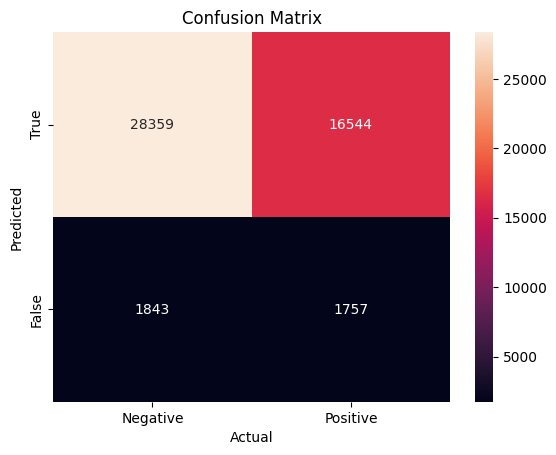

In [24]:
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], 
            yticklabels=['True', 'False'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

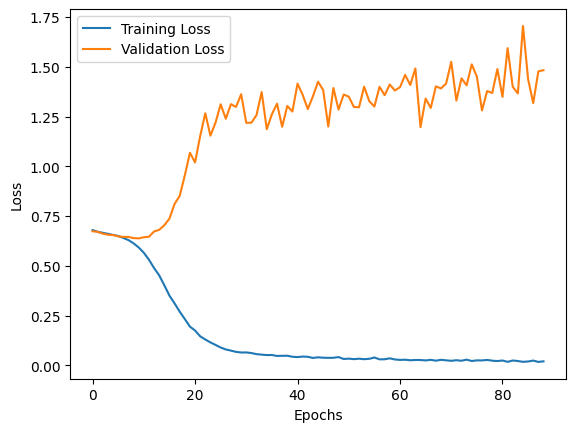

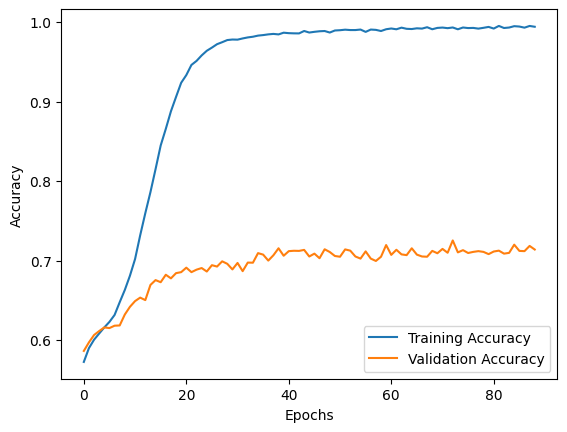

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_fed.history['loss'], label='Training Loss')
plt.plot(history_fed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_fed.history['accuracy'], label='Training Accuracy')
plt.plot(history_fed.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()